In [4]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import cv2
import shap
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, Xception, ResNet50, ResNet101
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from skfeature.function.information_theoretical_based import MRMR
from skfeature.function.similarity_based import reliefF
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from PIL import Image
import shutils

In [2]:
pip install pandoc

Note: you may need to restart the kernel to use updated packages.Collecting pandoc
  Created wheel for pandoc: filename=pandoc-2.4-py3-none-any.whl size=34823 sha256=88f8306b98e77f6aea0a794ffe0b0d955af67ba401cc1d19a762e90eecdce34b
  Stored in directory: c:\users\adhia\appdata\local\pip\cache\wheels\10\f8\26\ddf077e60385563a3fef3afad369a40b22e59603a700ec23e4
Successfully built pandoc



You should consider upgrading via the 'c:\users\adhia\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# DERMOSCOPIC PREPROCESSING 

# HAM10000 DATASET 

In [8]:

# Read the file explicitly as a CSV
metadata = pd.read_csv('HAM10000_metadata', low_memory=False)
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


In [3]:
metadata.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset  
0  vidir_modern  
1  vidir_modern  
2  vidir_modern  
3  vidir_modern  
4  vidir_modern

In [4]:
metadata.isna().isna().sum()


lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dataset         0
dtype: int64

In [5]:
metadata.describe(include='all')

lesion_id      image_id     dx dx_type          age    sex  \
count         10015         10015  10015   10015  9958.000000  10015   
unique         7470         10015      7       4          NaN      3   
top     HAM_0003789  ISIC_0027419     nv   histo          NaN   male   
freq              6             1   6705    5340          NaN   5406   
mean            NaN           NaN    NaN     NaN    51.863828    NaN   
std             NaN           NaN    NaN     NaN    16.968614    NaN   
min             NaN           NaN    NaN     NaN     0.000000    NaN   
25%             NaN           NaN    NaN     NaN    40.000000    NaN   
50%             NaN           NaN    NaN     NaN    50.000000    NaN   
75%             NaN           NaN    NaN     NaN    65.000000    NaN   
max             NaN           NaN    NaN     NaN    85.000000    NaN   

       localization        dataset  
count         10015          10015  
unique           15              4  
top            back  vidir_molemax  
freq           2192           3954  
mean            NaN            NaN  
std             NaN            NaN  
min             NaN            NaN  
25%             NaN            NaN  
50%             NaN            NaN  
75%             NaN            NaN  
max             NaN            NaN

# We need to predict the cancer type, let's check the distribution of the values


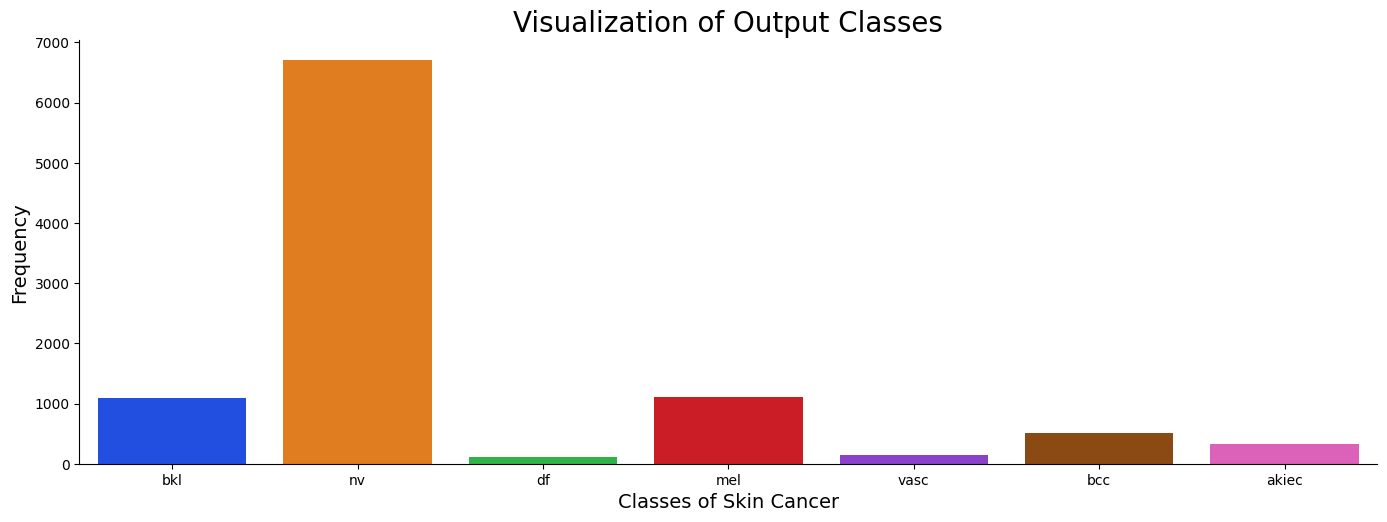

In [6]:
g = sns.catplot(x="dx", kind="count", palette='bright', data=metadata)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Visualization of Output Classes', fontsize=20)
g.set_xlabels('Classes of Skin Cancer', fontsize=14)
g.set_ylabels('Frequency', fontsize=14)

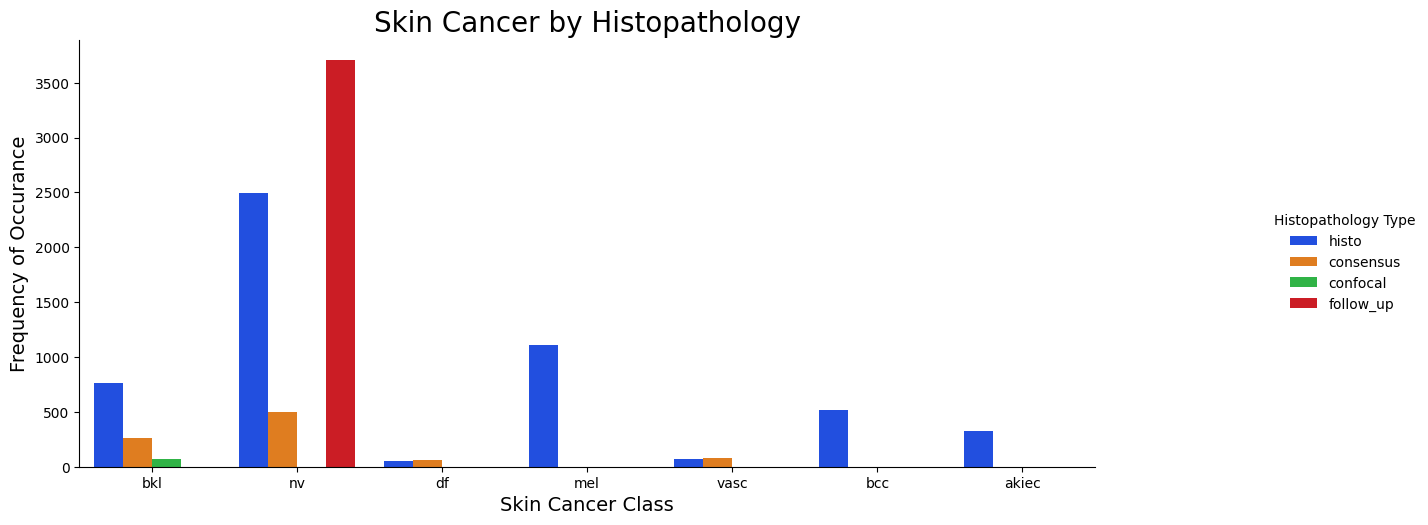

In [7]:
#Skin Cancer is confirmed via Hispathology, let's check the breakdown for each type
g = sns.catplot(x="dx", kind="count", hue="dx_type", palette='bright', data=metadata)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Histopathology', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Histopathology Type')

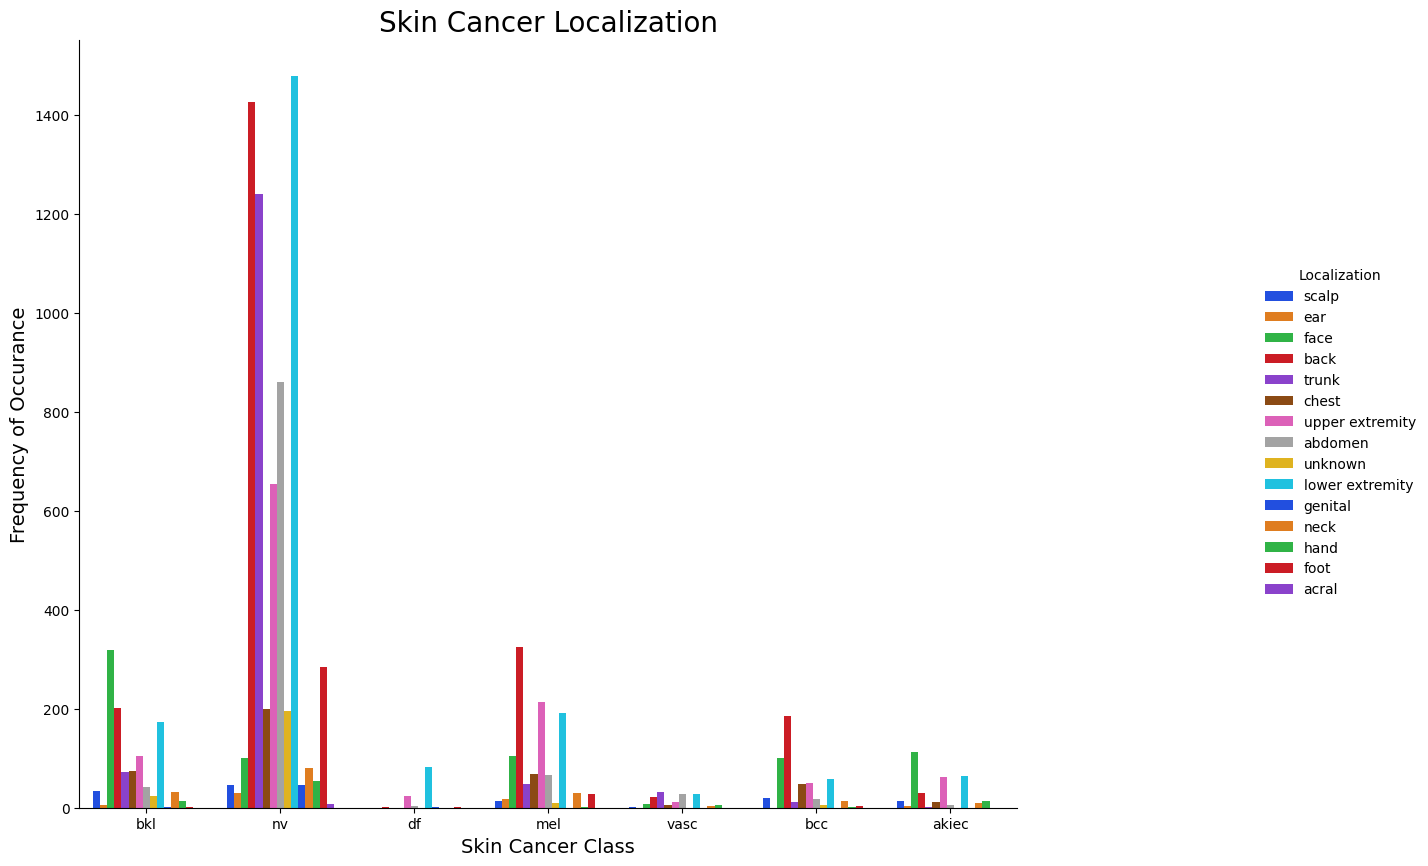

In [8]:
# Skin Cancer occurence body localization
g = sns.catplot(x="dx", kind="count", hue="localization", palette='bright', data=metadata)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer Localization', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Localization')

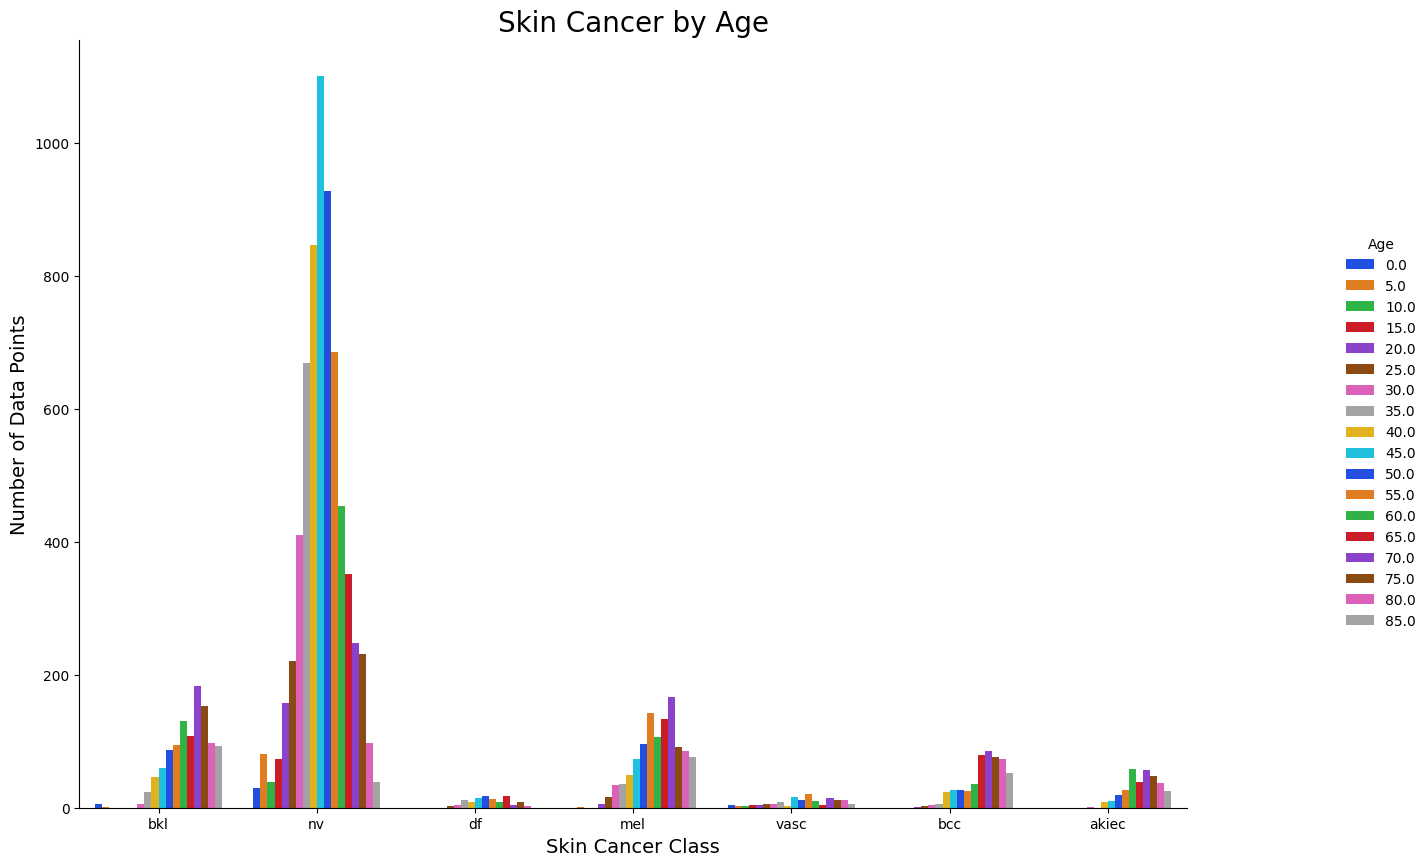

In [9]:
# Skin Cancer occurence by Age
g = sns.catplot(x="dx", kind="count", hue="age", palette='bright', data=metadata)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Age', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Age')

Text(0.5, 1.0, 'Gender of Patient')

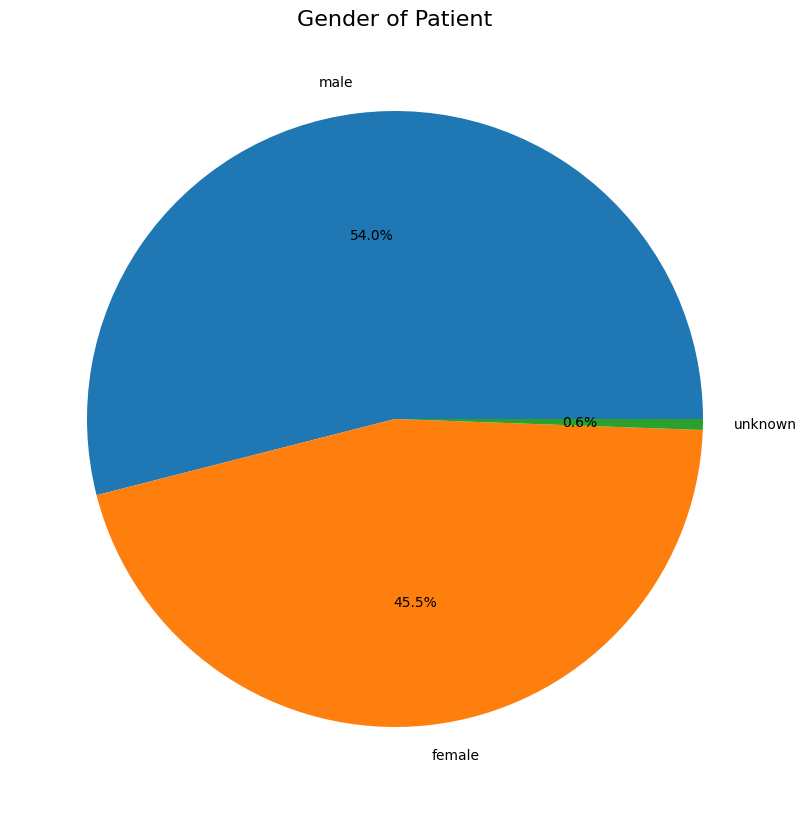

In [10]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(metadata['sex'].value_counts(), labels = metadata['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

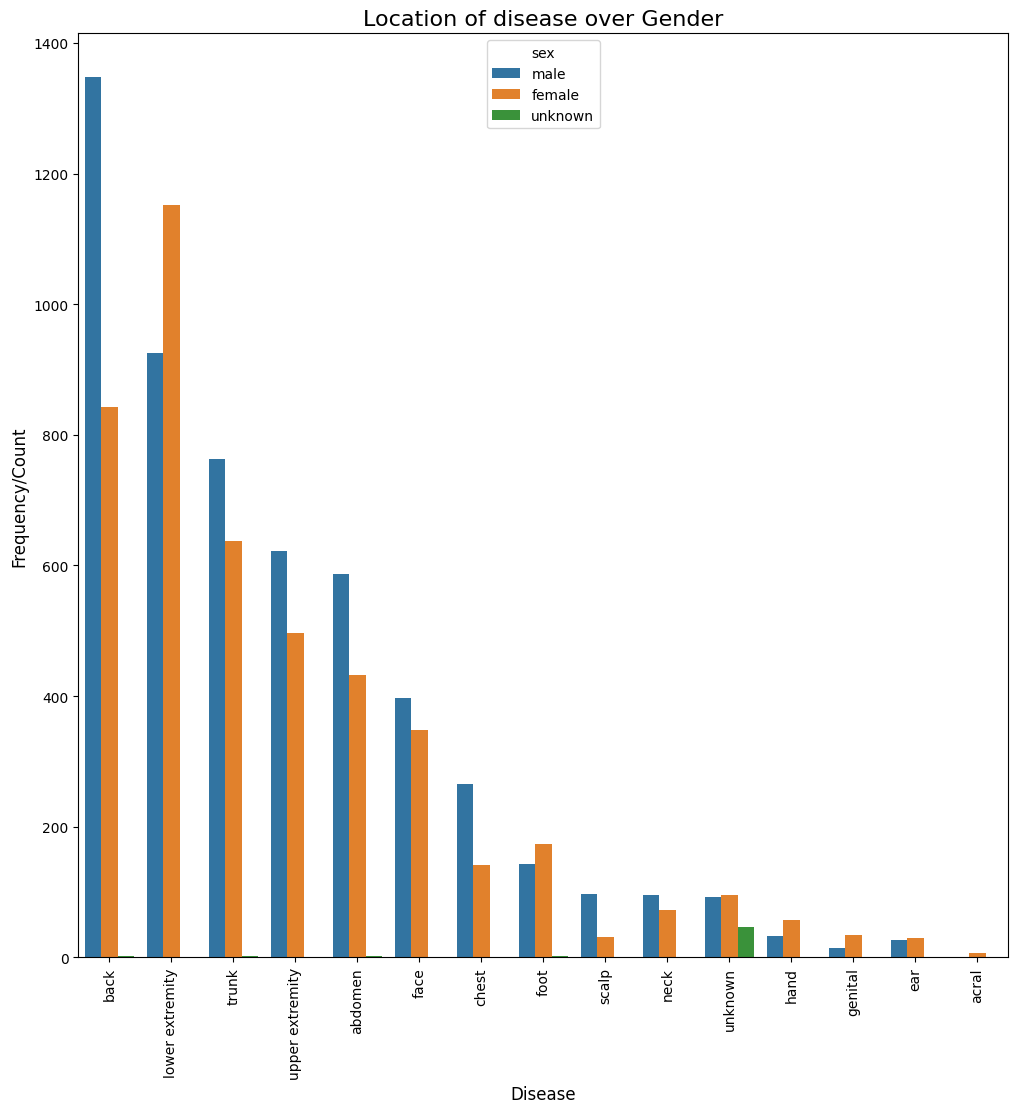

In [11]:
value = metadata[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

In [12]:
import os
import zipfile

# Define the paths to the ZIP files
zip_files = ['HAM10000_images_part_1.zip', 'HAM10000_images_part_2.zip']
output_dir = 'HAM10000_images'  # Folder to store extracted images

# Extract images if not already extracted
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    for zip_file in zip_files:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(output_dir)

print("All images extracted successfully.")


All images extracted successfully.


In [13]:
import os

# Define the unified image directory
image_dir = "HAM10000_images/"

# Function to get full image path
def get_image_path(image_id):
    filename = image_id + ".jpg"
    file_path = os.path.join(image_dir, filename)
    return file_path if os.path.exists(file_path) else None

# Apply function to metadata
metadata['image_path'] = metadata['image_id'].apply(get_image_path)

# Display first few rows
metadata.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset                        image_path  
0  vidir_modern  HAM10000_images/ISIC_0027419.jpg  
1  vidir_modern  HAM10000_images/ISIC_0025030.jpg  
2  vidir_modern  HAM10000_images/ISIC_0026769.jpg  
3  vidir_modern  HAM10000_images/ISIC_0025661.jpg  
4  vidir_modern  HAM10000_images/ISIC_0031633.jpg

In [14]:
import os
import cv2
import shutil
from tqdm import tqdm

# Define input and output directories
input_dir = 'HAM10000_images'
output_dirs = {
    'ResNet': 'HAM10000_resized_224', 
    'Inception_Xception': 'HAM10000_resized_229'
}

# Create output directories if not exist
for dir_name in output_dirs.values():
    os.makedirs(dir_name, exist_ok=True)

# Resize images based on CNN model requirements
for img_name in tqdm(os.listdir(input_dir), desc="Resizing Images"):
    img_path = os.path.join(input_dir, img_name)
    
    if img_name.lower().endswith(('.jpg', '.png')):  # Ensure it's an image
        img = cv2.imread(img_path)
        
        if img is not None:
            # Resize for ResNet (224x224)
            resized_resnet = cv2.resize(img, (224, 224))
            cv2.imwrite(os.path.join(output_dirs['ResNet'], img_name), resized_resnet)

            # Resize for Inception/Xception (229x229)
            resized_inception_xception = cv2.resize(img, (229, 229))
            cv2.imwrite(os.path.join(output_dirs['Inception_Xception'], img_name), resized_inception_xception)

print("✅ Image resizing completed!")

Resizing Images: 100%|███████████████████████████████████████████████████████████| 10015/10015 [03:19<00:00, 50.27it/s]

✅ Image resizing completed!


In [9]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image directories (Resized Images)
image_dir_224 = 'HAM10000_resized_224'  # For ResNet models
image_dir_229 = 'HAM10000_resized_229'  # For Inception & Xception

# Define split dataset directories
base_dir = 'HAM10000_split'
train_dir_224 = os.path.join(base_dir, 'train_224')
test_dir_224 = os.path.join(base_dir, 'test_224')
train_dir_229 = os.path.join(base_dir, 'train_229')
test_dir_229 = os.path.join(base_dir, 'test_229')

# Ensure base directories exist
for folder in [train_dir_224, test_dir_224, train_dir_229, test_dir_229]:
    os.makedirs(folder, exist_ok=True)


# Split into train and test (Stratified)
train_df, test_df = train_test_split(metadata, test_size=0.3, stratify=metadata['dx'], random_state=42)

# Function to copy images into respective class folders
def copy_images(df, split_dir, image_dir):
    for _, row in df.iterrows():
        class_label = row['dx']  # Class name
        img_name = row['image_id'] + '.jpg'
        src_path = os.path.join(image_dir, img_name)
        dest_class_dir = os.path.join(split_dir, class_label)  # Create class folder

        os.makedirs(dest_class_dir, exist_ok=True)  # Ensure class directory exists
        dest_path = os.path.join(dest_class_dir, img_name)

        if os.path.exists(src_path):  # Ensure image exists before copying
            shutil.copy(src_path, dest_path)

# Copy images into correct folders
copy_images(train_df, train_dir_224, image_dir_224)
copy_images(test_df, test_dir_224, image_dir_224)
copy_images(train_df, train_dir_229, image_dir_229)
copy_images(test_df, test_dir_229, image_dir_229)

print("✅ Train-test split completed! Images are organized by class.")

✅ Train-test split completed! Images are organized by class.


In [5]:
# Set batch size and image sizes
BATCH_SIZE = 32  
IMG_SIZE_224 = (224, 224)
IMG_SIZE_229 = (229, 229)

# Define augmentation techniques for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,         
    rotation_range=60,      # Rotating in horizontal and vertical directions (-60 to 60)
    width_shift_range=0.5,  # Scaling (0.5 to 1.5)
    height_shift_range=0.5, # Scaling (0.5 to 1.5)
    shear_range=50,         # Shearing perpendicularly (-50 to 50)
    zoom_range=[0.5, 1.5],  # Scaling (0.5 to 1.5)
    horizontal_flip=True,   # Flipping in horizontal direction
    vertical_flip=True      # Flipping in vertical direction
)


# Rescale test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:

# Load train and test images (224x224 for ResNet)
train_generator_224 = train_datagen.flow_from_directory(
    train_dir_224,
    target_size=IMG_SIZE_224,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator_224 = test_datagen.flow_from_directory(
    test_dir_224,
    target_size=IMG_SIZE_224,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load train and test images (229x229 for Inception & Xception)
train_generator_229 = train_datagen.flow_from_directory(
    train_dir_229,
    target_size=IMG_SIZE_229,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator_229 = test_datagen.flow_from_directory(
    test_dir_229,
    target_size=IMG_SIZE_229,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 7010 images belonging to 7 classes.
Found 3005 images belonging to 7 classes.
Found 7010 images belonging to 7 classes.
Found 3005 images belonging to 7 classes.


In [18]:

# Print dataset structure
print("\n✅ Data Augmentation Completed! Ready for CNN Training.")
print("\nTrain Classes:", os.listdir(train_dir_224))
for label in os.listdir(train_dir_224):
    print(f"🖼 {label}: {len(os.listdir(os.path.join(train_dir_224, label)))} images")



✅ Data Augmentation Completed! Ready for CNN Training.

Train Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
🖼 akiec: 229 images
🖼 bcc: 360 images
🖼 bkl: 769 images
🖼 df: 81 images
🖼 mel: 779 images
🖼 nv: 4693 images
🖼 vasc: 99 images


In [10]:
import os 
# Print test dataset structure
print("\n🔍 Test Dataset Structure:")
print("\nTest Classes:", os.listdir(test_dir_224))
for label in os.listdir(test_dir_224):
    print(f"📸 {label}: {len(os.listdir(os.path.join(test_dir_224, label)))} images")



🔍 Test Dataset Structure:

Test Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
📸 akiec: 98 images
📸 bcc: 154 images
📸 bkl: 330 images
📸 df: 34 images
📸 mel: 334 images
📸 nv: 2012 images
📸 vasc: 43 images


# SKIN CANCER : MALIGNANT VS BENIGN DATASET

In [19]:
# specifying path for train and test data folder
train_path = 'train'
test_path ='test'

In [20]:
import os
def plot_image(file, directory=None, sub=False, aspect=None):
    """ Function to display a single image """
    path = os.path.join(directory, file) if directory else file  # Corrected path concatenation
    
    if not os.path.exists(path):  # Check if file exists
        print(f"File not found: {path}")
        return

    img = plt.imread(path)
    
    plt.imshow(img, aspect=aspect)
    plt.xticks([])
    plt.yticks([])
    
    if sub:
        plt.show()

In [21]:
import os
def plot_img_dir(directory, count=5):
    """ Function to plot multiple images from a directory """
    files = os.listdir(directory)
    if not files:
        print(f"No images found in directory: {directory}")
        return
    
    selected_files = random.sample(files, min(count, len(files)))

    ncols = 5
    nrows = count // ncols if count % ncols == 0 else (count // ncols) + 1
    
    figsize = (20, 4 * nrows)  # Adjusted figure size
    
    plt.figure(figsize=figsize)

    for i, file in enumerate(selected_files):        
        plt.subplot(nrows, ncols, i + 1)
        plot_image(file, directory, aspect=None)  # Ensure `plot_image` is defined

    plt.tight_layout()
    plt.show()

In [22]:
import os
def plot_img_dir_main(directory, count=5):
    """ Function to plot images from multiple subdirectories """
    labels = os.listdir(directory)
    for label in labels:
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):  # Ensure it's a directory before processing
            print(f"Processing: {label}")
            plot_img_dir(label_path, count)

Processing: benign


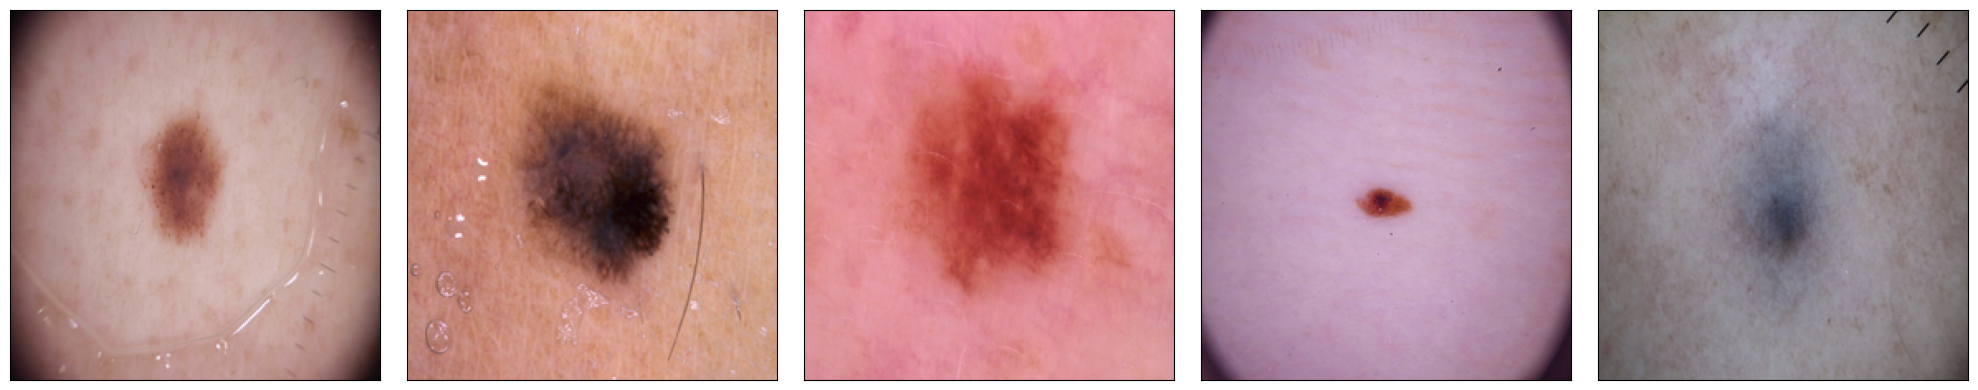

Processing: malignant


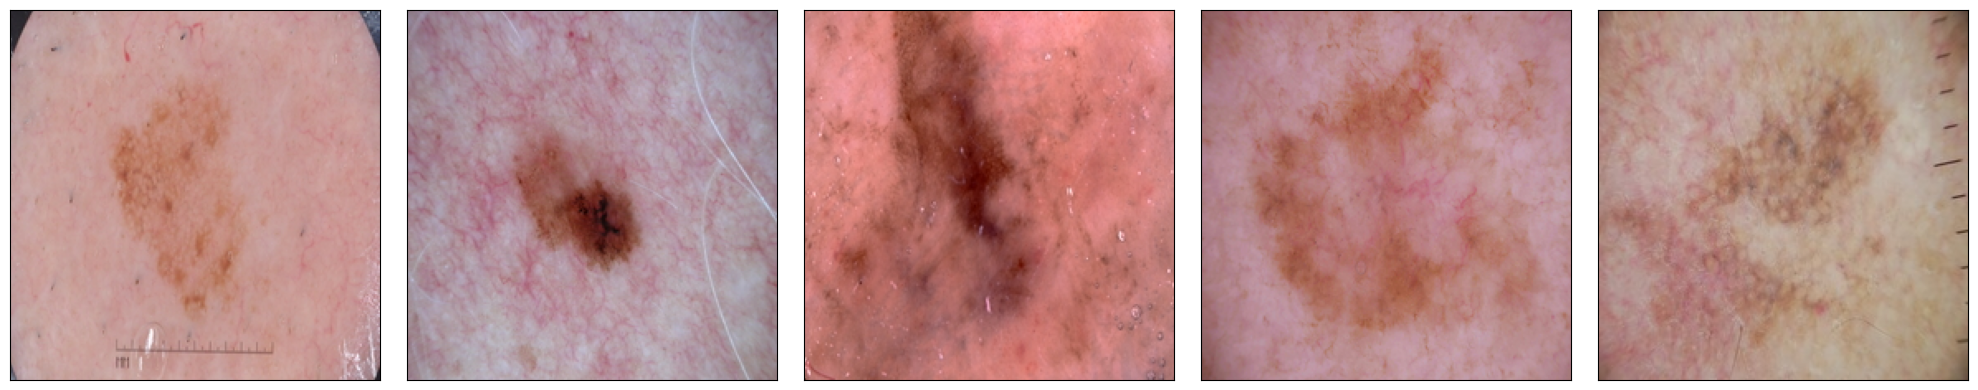

In [23]:
plot_img_dir_main('train', count=5)


In [24]:
resized_224_path = 'skin_cancer_224'
resized_229_path = 'skin_cancer_229'
split_data_path = 'skin_cancer_split'

# Ensure directories exist
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

create_dir(resized_224_path)
create_dir(resized_229_path)
create_dir(split_data_path)

In [25]:
# Resize images and save to respective folders
def resize_and_save(src_folder, dest_folder, size):
    create_dir(dest_folder)
    for category in ['benign', 'malignant']:
        src_category_path = os.path.join(src_folder, category)
        dest_category_path = os.path.join(dest_folder, category)
        create_dir(dest_category_path)
        
        for img_name in os.listdir(src_category_path):
            img_path = os.path.join(src_category_path, img_name)
            try:
                img = Image.open(img_path)
                img = img.resize(size)
                img.save(os.path.join(dest_category_path, img_name))
            except Exception as e:
                print(f"Error processing {img_name}: {e}")

In [26]:
# Perform resizing
resize_and_save(train_path, resized_224_path, (224, 224))
resize_and_save(test_path, resized_224_path, (224, 224))
resize_and_save(train_path, resized_229_path, (229, 229))
resize_and_save(test_path, resized_229_path, (229, 229))

In [27]:
# Function to split data into 70% train, 30% test
def split_data(src_folder, dest_folder, split_ratio=0.7):
    for category in ['benign', 'malignant']:
        src_category_path = os.path.join(src_folder, category)
        train_dest = os.path.join(dest_folder, f'train_{os.path.basename(src_folder)}', category)
        test_dest = os.path.join(dest_folder, f'test_{os.path.basename(src_folder)}', category)

        create_dir(train_dest)
        create_dir(test_dest)
        
        images = os.listdir(src_category_path)
        random.shuffle(images)
        split_index = int(len(images) * split_ratio)

        # Move 70% to training folder
        for img in images[:split_index]:
            shutil.copy(os.path.join(src_category_path, img), os.path.join(train_dest, img))

        # Move 30% to testing folder
        for img in images[split_index:]:
            shutil.copy(os.path.join(src_category_path, img), os.path.join(test_dest, img))

# Split both resized datasets into train and test
split_data(resized_224_path, split_data_path)
split_data(resized_229_path, split_data_path)


In [28]:
# Augmentation settings 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,      
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    shear_range=50,        
    zoom_range=[0.5, 1.5],  
    horizontal_flip=True,   
    vertical_flip=True
)

In [29]:
# No augmentation for test data
test_datagen = ImageDataGenerator(rescale=1./255)

In [30]:
# Load datasets for training and testing
training_set_224 = train_datagen.flow_from_directory(
    os.path.join(split_data_path, 'train_skin_cancer_224'),
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_set_224 = test_datagen.flow_from_directory(
    os.path.join(split_data_path, 'test_skin_cancer_224'),
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

training_set_229 = train_datagen.flow_from_directory(
    os.path.join(split_data_path, 'train_skin_cancer_229'),
    target_size=(229, 229),
    batch_size=64,
    class_mode='categorical'
)

test_set_229 = test_datagen.flow_from_directory(
    os.path.join(split_data_path, 'test_skin_cancer_229'),
    target_size=(229, 229),
    batch_size=64,
    class_mode='categorical'
)

Found 2307 images belonging to 2 classes.
Found 990 images belonging to 2 classes.
Found 2307 images belonging to 2 classes.
Found 990 images belonging to 2 classes.


In [31]:
import os

def print_dataset_details(base_path, dataset_name):
    print(f"\n===== {dataset_name} =====")
    
    total_images = 0
    for category in os.listdir(base_path):  # benign/malignant
        category_path = os.path.join(base_path, category)
        num_images = len(os.listdir(category_path))
        total_images += num_images
        print(f" - {category}: {num_images} images")

    print(f"Total images in {dataset_name}: {total_images}")

# Print details for 224x224 datasets
print_dataset_details('skin_cancer_split/train_skin_cancer_224', 'Train Skin Cancer Dataset (224x224)')
print_dataset_details('skin_cancer_split/test_skin_cancer_224', 'Test Skin Cancer Dataset (224x224)')

# Print details for 229x229 datasets
print_dataset_details('skin_cancer_split/train_skin_cancer_229', 'Train Skin Cancer Dataset (229x229)')
print_dataset_details('skin_cancer_split/test_skin_cancer_229', 'Test Skin Cancer Dataset (229x229)')





===== Train Skin Cancer Dataset (224x224) =====
 - benign: 1260 images
 - malignant: 1047 images
Total images in Train Skin Cancer Dataset (224x224): 2307

===== Test Skin Cancer Dataset (224x224) =====
 - benign: 540 images
 - malignant: 450 images
Total images in Test Skin Cancer Dataset (224x224): 990

===== Train Skin Cancer Dataset (229x229) =====
 - benign: 1260 images
 - malignant: 1047 images
Total images in Train Skin Cancer Dataset (229x229): 2307

===== Test Skin Cancer Dataset (229x229) =====
 - benign: 540 images
 - malignant: 450 images
Total images in Test Skin Cancer Dataset (229x229): 990


In [2]:
import os
import numpy as np
from tensorflow.keras.applications import InceptionV3, Xception, ResNet50, ResNet101
from tensorflow.keras.models import Model

# ===========================
# Define Pretrained CNN Models
# ===========================
models = {
    "ResNet50": ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3)),
    "ResNet101": ResNet101(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3)),
    "InceptionV3": InceptionV3(weights='imagenet', include_top=False, pooling='avg', input_shape=(229, 229, 3)),
    "Xception": Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(229, 229, 3))
}

print("✅ CNN Models Loaded Successfully!")

✅ CNN Models Loaded Successfully!


In [3]:
def extract_features(model, generator):
    """ Efficiently extract features from CNN's last layer using predict_generator """
    features = model.predict(generator, verbose=1)  # Process all images at once
    labels = generator.classes  # Get class labels
    return features, labels

In [34]:
# ===========================
# Extract Features from CNNs (HAM10000 & Skin Cancer Datasets) - Optimized
# ===========================
for model_name in models.keys():
    for dataset, train_gen, test_gen in [("ham", train_generator_224, test_generator_224), ("skin", training_set_224, test_set_224)]:
        if model_name in ["ResNet50", "ResNet101"]:
            globals()[f"X_train_features_224_{dataset}_{model_name}"], globals()[f"y_train_224_{dataset}_{model_name}"] = extract_features(models[model_name], train_gen)
            globals()[f"X_test_features_224_{dataset}_{model_name}"], globals()[f"y_test_224_{dataset}_{model_name}"] = extract_features(models[model_name], test_gen)
    
    for dataset, train_gen, test_gen in [("ham", train_generator_229, test_generator_229), ("skin", training_set_229, test_set_229)]:
        if model_name in ["InceptionV3", "Xception"]:
            globals()[f"X_train_features_229_{dataset}_{model_name}"], globals()[f"y_train_229_{dataset}_{model_name}"] = extract_features(models[model_name], train_gen)
            globals()[f"X_test_features_229_{dataset}_{model_name}"], globals()[f"y_test_229_{dataset}_{model_name}"] = extract_features(models[model_name], test_gen)

# ===========================

c:\users\adhia\appdata\local\programs\python\python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


220/220 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 75s 799ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step


In [8]:
import numpy as np

for model_name in models.keys():
    for dataset in ["ham", "skin"]:
        if model_name in ["ResNet50", "ResNet101"]:
            np.save(f'X_train_features_224_{dataset}_{model_name}.npy', globals()[f"X_train_features_224_{dataset}_{model_name}"])
            np.save(f'y_train_224_{dataset}_{model_name}.npy', globals()[f"y_train_224_{dataset}_{model_name}"])
            np.save(f'X_test_features_224_{dataset}_{model_name}.npy', globals()[f"X_test_features_224_{dataset}_{model_name}"])
            np.save(f'y_test_224_{dataset}_{model_name}.npy', globals()[f"y_test_224_{dataset}_{model_name}"])

        if model_name in ["InceptionV3", "Xception"]:
            np.save(f'X_train_features_229_{dataset}_{model_name}.npy', globals()[f"X_train_features_229_{dataset}_{model_name}"])
            np.save(f'y_train_229_{dataset}_{model_name}.npy', globals()[f"y_train_229_{dataset}_{model_name}"])
            np.save(f'X_test_features_229_{dataset}_{model_name}.npy', globals()[f"X_test_features_229_{dataset}_{model_name}"])
            np.save(f'y_test_229_{dataset}_{model_name}.npy', globals()[f"y_test_229_{dataset}_{model_name}"])


In [12]:
import numpy as np

for model_name in models.keys():
    for dataset in ["ham", "skin"]:
        if model_name in ["ResNet50", "ResNet101"]:
            globals()[f"X_train_features_224_{dataset}_{model_name}"] = np.load(f'X_train_features_224_{dataset}_{model_name}.npy')
            globals()[f"y_train_224_{dataset}_{model_name}"] = np.load(f'y_train_224_{dataset}_{model_name}.npy')
            globals()[f"X_test_features_224_{dataset}_{model_name}"] = np.load(f'X_test_features_224_{dataset}_{model_name}.npy')
            globals()[f"y_test_224_{dataset}_{model_name}"] = np.load(f'y_test_224_{dataset}_{model_name}.npy')

        if model_name in ["InceptionV3", "Xception"]:
            globals()[f"X_train_features_229_{dataset}_{model_name}"] = np.load(f'X_train_features_229_{dataset}_{model_name}.npy')
            globals()[f"y_train_229_{dataset}_{model_name}"] = np.load(f'y_train_229_{dataset}_{model_name}.npy')
            globals()[f"X_test_features_229_{dataset}_{model_name}"] = np.load(f'X_test_features_229_{dataset}_{model_name}.npy')
            globals()[f"y_test_229_{dataset}_{model_name}"] = np.load(f'y_test_229_{dataset}_{model_name}.npy')


In [10]:
for model_name in models.keys():
    for dataset in ["ham", "skin"]:
        if model_name in ["ResNet50", "ResNet101"]:
            print(f"Loaded {model_name} - {dataset} (224x224)")
            print("X_train:", globals()[f"X_train_features_224_{dataset}_{model_name}"].shape)
            print("y_train:", globals()[f"y_train_224_{dataset}_{model_name}"].shape)
            print("X_test:", globals()[f"X_test_features_224_{dataset}_{model_name}"].shape)
            print("y_test:", globals()[f"y_test_224_{dataset}_{model_name}"].shape)

        if model_name in ["InceptionV3", "Xception"]:
            print(f"Loaded {model_name} - {dataset} (229x229)")
            print("X_train:", globals()[f"X_train_features_229_{dataset}_{model_name}"].shape)
            print("y_train:", globals()[f"y_train_229_{dataset}_{model_name}"].shape)
            print("X_test:", globals()[f"X_test_features_229_{dataset}_{model_name}"].shape)
            print("y_test:", globals()[f"y_test_229_{dataset}_{model_name}"].shape)


Loaded ResNet50 - ham (224x224)
X_train: (7010, 2048)
y_train: (7010,)
X_test: (3005, 2048)
y_test: (3005,)
Loaded ResNet50 - skin (224x224)
X_train: (2307, 2048)
y_train: (2307,)
X_test: (990, 2048)
y_test: (990,)
Loaded ResNet101 - ham (224x224)
X_train: (7010, 2048)
y_train: (7010,)
X_test: (3005, 2048)
y_test: (3005,)
Loaded ResNet101 - skin (224x224)
X_train: (2307, 2048)
y_train: (2307,)
X_test: (990, 2048)
y_test: (990,)
Loaded InceptionV3 - ham (229x229)
X_train: (7010, 2048)
y_train: (7010,)
X_test: (3005, 2048)
y_test: (3005,)
Loaded InceptionV3 - skin (229x229)
X_train: (2307, 2048)
y_train: (2307,)
X_test: (990, 2048)
y_test: (990,)
Loaded Xception - ham (229x229)
X_train: (7010, 2048)
y_train: (7010,)
X_test: (3005, 2048)
y_test: (3005,)
Loaded Xception - skin (229x229)
X_train: (2307, 2048)
y_train: (2307,)
X_test: (990, 2048)
y_test: (990,)


In [32]:
# feature reduction using PCA


from sklearn.decomposition import PCA

pca = PCA(n_components=100)  # Based on the ablation study in Skin-CAD

for model_name in models.keys():
    for dataset in ["ham", "skin"]:
        if model_name in ["ResNet50", "ResNet101"]:
            X_train_pca = pca.fit_transform(np.load(f'X_train_features_224_{dataset}_{model_name}.npy'))
            X_test_pca = pca.transform(np.load(f'X_test_features_224_{dataset}_{model_name}.npy'))

            np.save(f'X_train_PCA_224_{dataset}_{model_name}.npy', X_train_pca)
            np.save(f'X_test_PCA_224_{dataset}_{model_name}.npy', X_test_pca)

        if model_name in ["InceptionV3", "Xception"]:
            X_train_pca = pca.fit_transform(np.load(f'X_train_features_229_{dataset}_{model_name}.npy'))
            X_test_pca = pca.transform(np.load(f'X_test_features_229_{dataset}_{model_name}.npy'))

            np.save(f'X_train_PCA_229_{dataset}_{model_name}.npy', X_train_pca)
            np.save(f'X_test_PCA_229_{dataset}_{model_name}.npy', X_test_pca)



In [3]:
import numpy as np

models = ["ResNet50", "ResNet101", "InceptionV3", "Xception"]
datasets = ["ham", "skin"]
image_sizes = {"ResNet50": 224, "ResNet101": 224, "InceptionV3": 229, "Xception": 229}

# Ensure only a limited number of elements are printed
np.set_printoptions(threshold=20, edgeitems=3, precision=3, suppress=True)

for model_name in models:
    for dataset in datasets:
        img_size = image_sizes[model_name]
        
        # Load PCA-transformed training and test sets
        X_train_pca = np.load(f'X_train_PCA_{img_size}_{dataset}_{model_name}.npy')
        X_test_pca = np.load(f'X_test_PCA_{img_size}_{dataset}_{model_name}.npy')

        # Print dataset information
        print(f"\nModel: {model_name} - Dataset: {dataset} ({img_size}x{img_size})")
        print(f"X_train_PCA shape: {X_train_pca.shape}")
        print(f"X_test_PCA shape: {X_test_pca.shape}")
        print("-" * 50)

        # Print exactly two rows, formatted properly
        print("Sample PCA features (Train) [2 rows]:")
        print("\n".join([str(row) for row in X_train_pca[:2]]))  

        print("\nSample PCA features (Test) [2 rows]:")
        print("\n".join([str(row) for row in X_test_pca[:2]]))  

        print("=" * 100)



Model: ResNet50 - Dataset: ham (224x224)
X_train_PCA shape: (7010, 500)
X_test_PCA shape: (3005, 500)
--------------------------------------------------
Sample PCA features (Train) [2 rows]:
[-0.071 -0.1   -0.067 ...  0.     0.    -0.   ]
[-0.126 -0.114 -0.027 ...  0.    -0.     0.   ]

Sample PCA features (Test) [2 rows]:
[ 0.162 -0.006 -0.18  ...  0.001 -0.    -0.001]
[-0.069  0.157 -0.039 ... -0.     0.     0.   ]

Model: ResNet50 - Dataset: skin (224x224)
X_train_PCA shape: (2307, 500)
X_test_PCA shape: (990, 500)
--------------------------------------------------
Sample PCA features (Train) [2 rows]:
[-0.119  0.098 -0.122 ... -0.     0.    -0.   ]
[ 0.414 -0.373  0.012 ... -0.     0.     0.   ]

Sample PCA features (Test) [2 rows]:
[-0.204  0.019  0.007 ... -0.    -0.     0.   ]
[-0.287  0.118 -0.02  ...  0.    -0.     0.   ]

Model: ResNet101 - Dataset: ham (224x224)
X_train_PCA shape: (7010, 500)
X_test_PCA shape: (3005, 500)
--------------------------------------------------
S

In [33]:
# feature fusion (reduced Pooling features using pca + fully Connected layers)


for model_name in models.keys():
    for dataset in ["ham", "skin"]:
        if model_name in ["ResNet50", "ResNet101"]:
            X_train_pca = np.load(f'X_train_PCA_224_{dataset}_{model_name}.npy')
            X_test_pca = np.load(f'X_test_PCA_224_{dataset}_{model_name}.npy')
            y_train = np.load(f'y_train_224_{dataset}_{model_name}.npy')
            y_test = np.load(f'y_test_224_{dataset}_{model_name}.npy')

            X_train_fused = np.hstack((X_train_pca, y_train.reshape(-1, 1)))
            X_test_fused = np.hstack((X_test_pca, y_test.reshape(-1, 1)))

            np.save(f'X_train_FUSED_224_{dataset}_{model_name}.npy', X_train_fused)
            np.save(f'X_test_FUSED_224_{dataset}_{model_name}.npy', X_test_fused)

        if model_name in ["InceptionV3", "Xception"]:
            X_train_pca = np.load(f'X_train_PCA_229_{dataset}_{model_name}.npy')
            X_test_pca = np.load(f'X_test_PCA_229_{dataset}_{model_name}.npy')
            y_train = np.load(f'y_train_229_{dataset}_{model_name}.npy')
            y_test = np.load(f'y_test_229_{dataset}_{model_name}.npy')

            X_train_fused = np.hstack((X_train_pca, y_train.reshape(-1, 1)))
            X_test_fused = np.hstack((X_test_pca, y_test.reshape(-1, 1)))

            np.save(f'X_train_FUSED_229_{dataset}_{model_name}.npy', X_train_fused)
            np.save(f'X_test_FUSED_229_{dataset}_{model_name}.npy', X_test_fused)


In [2]:
import numpy as np

models = ["ResNet50", "ResNet101", "InceptionV3", "Xception"]
datasets = ["ham", "skin"]
image_sizes = {"ResNet50": 224, "ResNet101": 224, "InceptionV3": 229, "Xception": 229}

for model_name in models:
    for dataset in datasets:
        img_size = image_sizes[model_name]
        
        # Load fused feature datasets
        X_train_fused = np.load(f'X_train_FUSED_{img_size}_{dataset}_{model_name}.npy')
        X_test_fused = np.load(f'X_test_FUSED_{img_size}_{dataset}_{model_name}.npy')

        # Print dataset information
        print(f"Model: {model_name} - Dataset: {dataset} ({img_size}x{img_size})")
        print(f"X_train_FUSED shape: {X_train_fused.shape}")
        print(f"X_test_FUSED shape: {X_test_fused.shape}")
        print("-" * 50)

        # Print a small sample of the fused features (first 2 rows)
        print("Sample FUSED features (Train):")
        print(X_train_fused[:2])  
        print("\nSample FUSED features (Test):")
        print(X_test_fused[:2])  
        print("=" * 100)


Model: ResNet50 - Dataset: ham (224x224)
X_train_FUSED shape: (7010, 501)
X_test_FUSED shape: (3005, 501)
--------------------------------------------------
Sample FUSED features (Train):
[[-7.07237795e-02 -1.00102015e-01 -6.68415427e-02 ...  1.02369931e-05
  -7.63902972e-06  0.00000000e+00]
 [-1.25747010e-01 -1.14152372e-01 -2.68290881e-02 ... -1.04272440e-05
   2.37232580e-05  0.00000000e+00]]

Sample FUSED features (Test):
[[ 1.62376612e-01 -5.68656437e-03 -1.80103898e-01 ... -4.07172134e-04
  -1.24470843e-03  0.00000000e+00]
 [-6.89618438e-02  1.57317564e-01 -3.90458740e-02 ...  1.32605841e-04
   2.95064063e-04  0.00000000e+00]]
Model: ResNet50 - Dataset: skin (224x224)
X_train_FUSED shape: (2307, 501)
X_test_FUSED shape: (990, 501)
--------------------------------------------------
Sample FUSED features (Train):
[[-1.18546247e-01  9.78545547e-02 -1.21558957e-01 ...  1.56342881e-04
  -1.49166299e-04  0.00000000e+00]
 [ 4.14085925e-01 -3.73356700e-01  1.20214252e-02 ...  1.68080820e

In [18]:
from skfeature.function.information_theoretical_based import MRMR
from skfeature.function.similarity_based import reliefF
import numpy as np

num_selected_features = 50  # Based on Skin-CAD's ablation study

for dataset in ["ham", "skin"]:
    for resolution, applicable_models in [("224", ["ResNet50", "ResNet101"]), ("229", ["InceptionV3", "Xception"])]:
        try:
            # Separate lists for training and test features
            train_features = []
            test_features = []
            y_train, y_test = None, None  # Labels will be the same across all models

            for model_name in applicable_models:
                # Load features
                X_train_fused = np.load(f'X_train_FUSED_{resolution}_{dataset}_{model_name}.npy')
                X_test_fused = np.load(f'X_test_FUSED_{resolution}_{dataset}_{model_name}.npy')

                train_features.append(X_train_fused)  # Append train features
                test_features.append(X_test_fused)    # Append test features

                if y_train is None:
                    y_train = np.load(f'y_train_{resolution}_{dataset}_{model_name}.npy')
                    y_test = np.load(f'y_test_{resolution}_{dataset}_{model_name}.npy')

            # Combine all CNN features separately for training and test sets
            X_train_combined = np.hstack(train_features)  # Train set
            X_test_combined = np.hstack(test_features)    # Test set

            # Apply MRMR
            selected_features_mrmr = MRMR.mrmr(X_train_combined, y_train, n_selected_features=num_selected_features)
            X_train_mrmr = X_train_combined[:, selected_features_mrmr]
            X_test_mrmr = X_test_combined[:, selected_features_mrmr]

            np.save(f'X_train_SELECTED_MRMR_{resolution}_{dataset}.npy', X_train_mrmr)
            np.save(f'X_test_SELECTED_MRMR_{resolution}_{dataset}.npy', X_test_mrmr)

            # Apply Relief-F
            selected_features_relief = reliefF.reliefF(X_train_combined, y_train)
            top_relief_features = selected_features_relief[:num_selected_features]
            X_train_relief = X_train_combined[:, top_relief_features]
            X_test_relief = X_test_combined[:, top_relief_features]

            np.save(f'X_train_SELECTED_RELIEF_{resolution}_{dataset}.npy', X_train_relief)
            np.save(f'X_test_SELECTED_RELIEF_{resolution}_{dataset}.npy', X_test_relief)

            print(f"Feature selection completed for {dataset} ({resolution}x{resolution}) using MRMR & Relief-F")

        except FileNotFoundError:
            print(f"Skipping {dataset} ({resolution}x{resolution}), features not found.")


Feature selection completed for ham (224x224) using MRMR & Relief-F
Feature selection completed for ham (229x229) using MRMR & Relief-F
Feature selection completed for skin (224x224) using MRMR & Relief-F
Feature selection completed for skin (229x229) using MRMR & Relief-F


# CLASSIFICATION

## SKIN CANCER DATASET


=== ResNet50 - skin (224x224) ===
Accuracy Score for ResNet50: 0.9273
Soft Voting ROC AUC for ResNet50: 1.0000


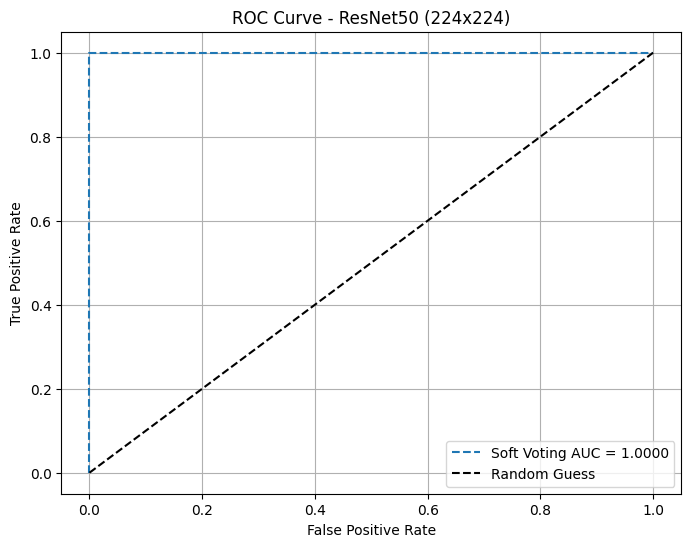


=== ResNet101 - skin (224x224) ===
Accuracy Score for ResNet101: 0.9418
Soft Voting ROC AUC for ResNet101: 1.0000


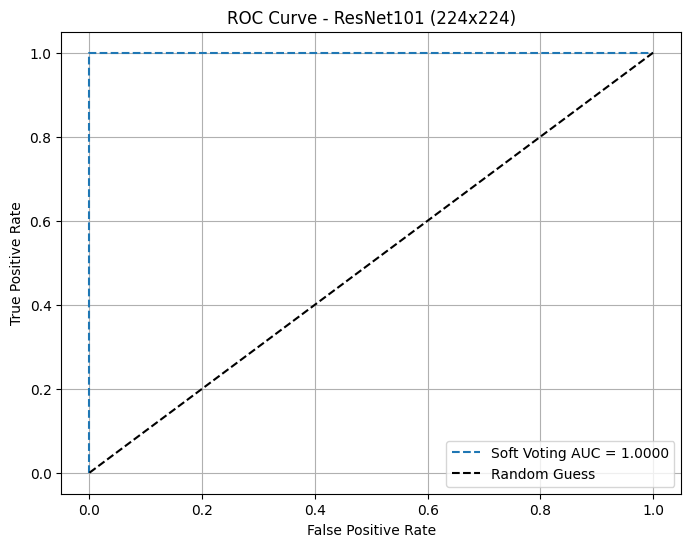

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

dataset = "skin"


for resolution, applicable_models in [("224", ["ResNet50", "ResNet101"])]:
    try:
        for idx, model_name in enumerate(applicable_models):
            print(f"\n=== {model_name} - {dataset} ({resolution}x{resolution}) ===")
            y_train = np.load(f'y_train_{resolution}_{dataset}_{model_name}.npy')
            y_test = np.load(f'y_test_{resolution}_{dataset}_{model_name}.npy')
            X_train_fused = np.load(f'X_train_SELECTED_MRMR_{resolution}_{dataset}_{model_name}.npy')
            X_test_fused = np.load(f'X_test_SELECTED_MRMR_{resolution}_{dataset}_{model_name}.npy')
            #base estimators 
            clf1 = LogisticRegression(max_iter=1000)
            clf2 = RandomForestClassifier(n_estimators=100)
            clf3 = SVC(probability=True)
            ensemble = VotingClassifier(
                estimators=[('lr', clf1), ('rf', clf2), ('svc', clf3)],
                voting='soft'
            )
            ensemble.fit(X_train_fused, y_train)
            y_pred = ensemble.predict(X_test_fused)
            accu = accuracy_score(y_test, y_pred)
            y_prob = ensemble.predict_proba(X_test_fused)[:, 1]
            auc = roc_auc_score(y_test, y_prob)
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            print(f"Accuracy Score for {model_name}: {accus[idx]:.4f}")
            print(f"Soft Voting ROC AUC for {model_name}: {auc:.4f}")
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'Soft Voting AUC = {auc:.4f}', linestyle='--')
            plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {model_name} ({resolution}x{resolution})')
            plt.legend()
            plt.grid()
            plt.show()

    except FileNotFoundError:
        print(f"Skipping {dataset} ({resolution}x{resolution}) - features not found.")


## HAM10000 DATASET


=== InceptionV3 - ham (229x229) ===
Accuracy for InceptionV3: 0.9730
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93        98
           1       0.93      0.99      0.96       154
           2       0.93      1.00      0.96       330
           3       1.00      0.03      0.06        34
           4       0.98      1.00      0.99       334
           5       0.98      1.00      0.99      2012
           6       1.00      0.19      0.31        43

    accuracy                           0.97      3005
   macro avg       0.97      0.73      0.74      3005
weighted avg       0.97      0.97      0.96      3005



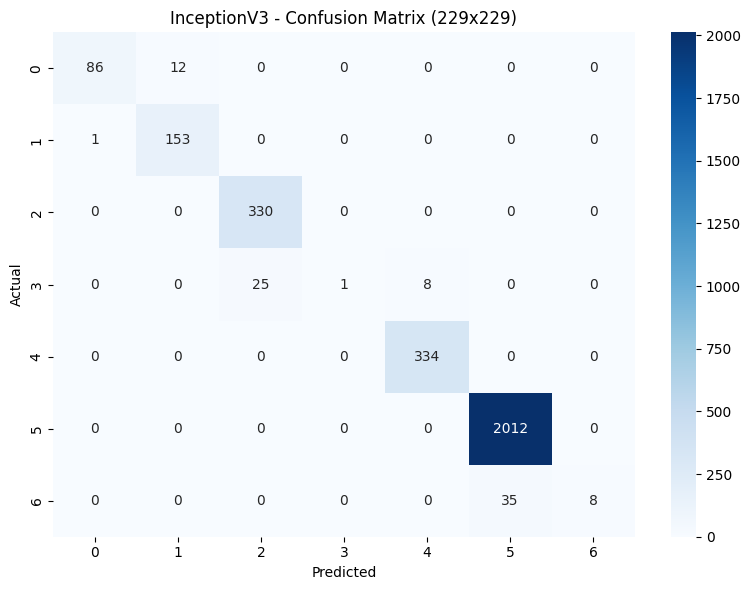


=== Xception - ham (229x229) ===
Accuracy for Xception: 0.9900
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        98
           1       0.99      1.00      1.00       154
           2       0.97      1.00      0.98       330
           3       1.00      0.62      0.76        34
           4       0.99      1.00      1.00       334
           5       0.99      1.00      1.00      2012
           6       1.00      0.63      0.77        43

    accuracy                           0.99      3005
   macro avg       0.99      0.89      0.93      3005
weighted avg       0.99      0.99      0.99      3005



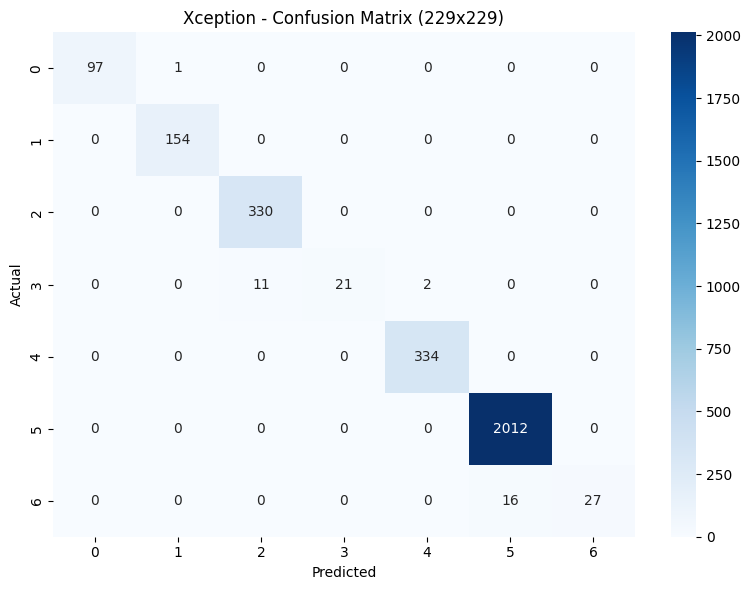

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

dataset = "ham"

for resolution, applicable_models in [("229", ["InceptionV3", "Xception"])]:
    try:
        for model_name in applicable_models:
            print(f"\n=== {model_name} - {dataset} ({resolution}x{resolution}) ===")
            y_train = np.load(f'y_train_{resolution}_{dataset}_{model_name}.npy')
            y_test = np.load(f'y_test_{resolution}_{dataset}_{model_name}.npy')
            X_train_fused = np.load(f'X_train_SELECTED_MRMR_{resolution}_{dataset}_{model_name}.npy')
            X_test_fused = np.load(f'X_test_SELECTED_MRMR_{resolution}_{dataset}_{model_name}.npy')

            clf1 = LogisticRegression(max_iter=1000)
            clf2 = RandomForestClassifier(n_estimators=100)
            clf3 = SVC(probability=True)

            ensemble = VotingClassifier(
                estimators=[('lr', clf1), ('rf', clf2), ('svc', clf3)],
                voting='soft'
            )
            ensemble.fit(X_train_fused, y_train)
            y_pred = ensemble.predict(X_test_fused)

            accuracy = accuracy_score(y_test, y_pred)
            print(f"Accuracy for {model_name}: {accuracy:.4f}")

            # Classification Report
            print("Classification Report:")
            print(classification_report(y_test, y_pred))

            # Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'{model_name} - Confusion Matrix ({resolution}x{resolution})')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.tight_layout()
            plt.show()

    except FileNotFoundError:
        print(f"Skipping {dataset} ({resolution}x{resolution}) - features not found.")


# GRADCAM VISUALIZATION 

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


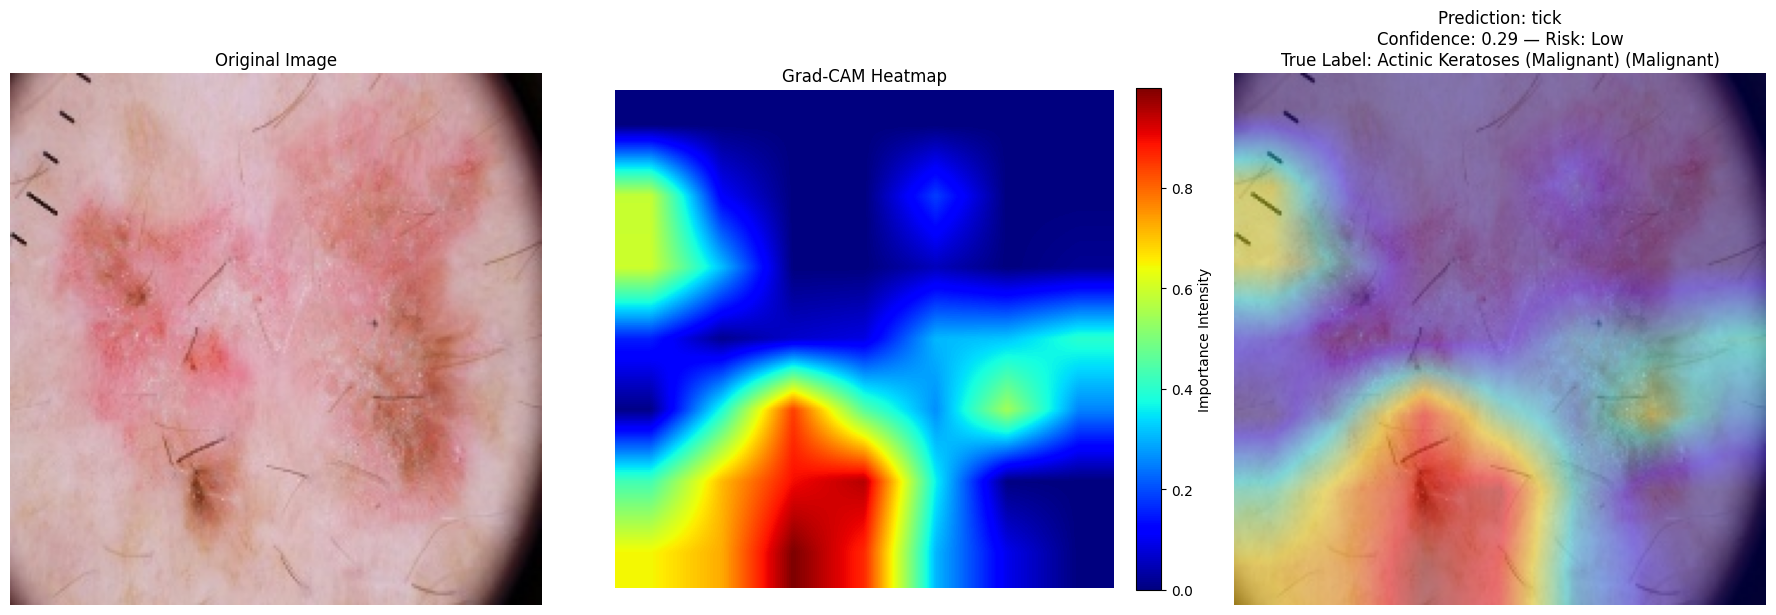

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# === Load model ===
model = ResNet50(weights='imagenet')

# === Image and metadata paths ===
img_path = os.path.join('HAM10000_split', 'test_224', 'akiec', 'ISIC_0024450.jpg')
metadata_path = 'HAM10000_metadata'

# === Load and preprocess image ===
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# === Predict ===
preds = model.predict(x)
decoded = decode_predictions(preds, top=3)[0]
pred_label = decoded[0][1]
pred_confidence = decoded[0][2]
pred_class = np.argmax(preds[0])

# === Risk interpretation ===
if pred_confidence >= 0.85:
    risk = "High"
elif pred_confidence >= 0.60:
    risk = "Moderate"
else:
    risk = "Low"

# === Load metadata CSV ===
label_map = {
    'akiec': 'Actinic Keratoses (Malignant)',
    'bcc': 'Basal Cell Carcinoma (Malignant)',
    'bkl': 'Benign Keratosis (Benign)',
    'df': 'Dermatofibroma (Benign)',
    'mel': 'Melanoma (Malignant)',
    'nv': 'Melanocytic Nevi (Benign)',
    'vasc': 'Vascular Lesion (Benign)'
}
malignant_labels = {'akiec', 'bcc', 'mel'}

metadata = pd.read_csv(metadata_path)
img_id = os.path.basename(img_path).split('.')[0]
dx_row = metadata[metadata['image_id'] == img_id]

if dx_row.empty:
    actual_dx = 'Unknown'
    dx_type = 'Unknown'
else:
    dx = dx_row.iloc[0]['dx']
    actual_dx = label_map.get(dx, dx)
    dx_type = 'Malignant' if dx in malignant_labels else 'Benign'

# === Grad-CAM heatmap ===
grad_model = Model(
    inputs=model.inputs,
    outputs=[model.get_layer('conv5_block3_out').output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    loss = predictions[:, pred_class]

grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= tf.math.reduce_max(heatmap)
heatmap_np = heatmap.numpy()

# === Prepare images ===
img_cv = cv2.imread(img_path)
img_cv = cv2.resize(img_cv, (224, 224))
heatmap_resized = cv2.resize(heatmap_np, (img_cv.shape[1], img_cv.shape[0]))
heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap_color, 0.4, 0)

# === Display ===
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Original
axs[0].imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Image")
axs[0].axis('off')

# Heatmap only
heatmap_plot = axs[1].imshow(heatmap_resized, cmap='jet')
axs[1].set_title("Grad-CAM Heatmap")
axs[1].axis('off')
cbar = plt.colorbar(heatmap_plot, ax=axs[1], fraction=0.046, pad=0.04)
cbar.set_label('Importance Intensity')

# Overlay + metadata info
axs[2].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
axs[2].set_title(
    f"Prediction: {pred_label}\n"
    f"Confidence: {pred_confidence:.2f} — Risk: {risk}\n"
    f"True Label: {actual_dx} ({dx_type})"
)
axs[2].axis('off')

plt.tight_layout()
plt.show()


179648224/179648224 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


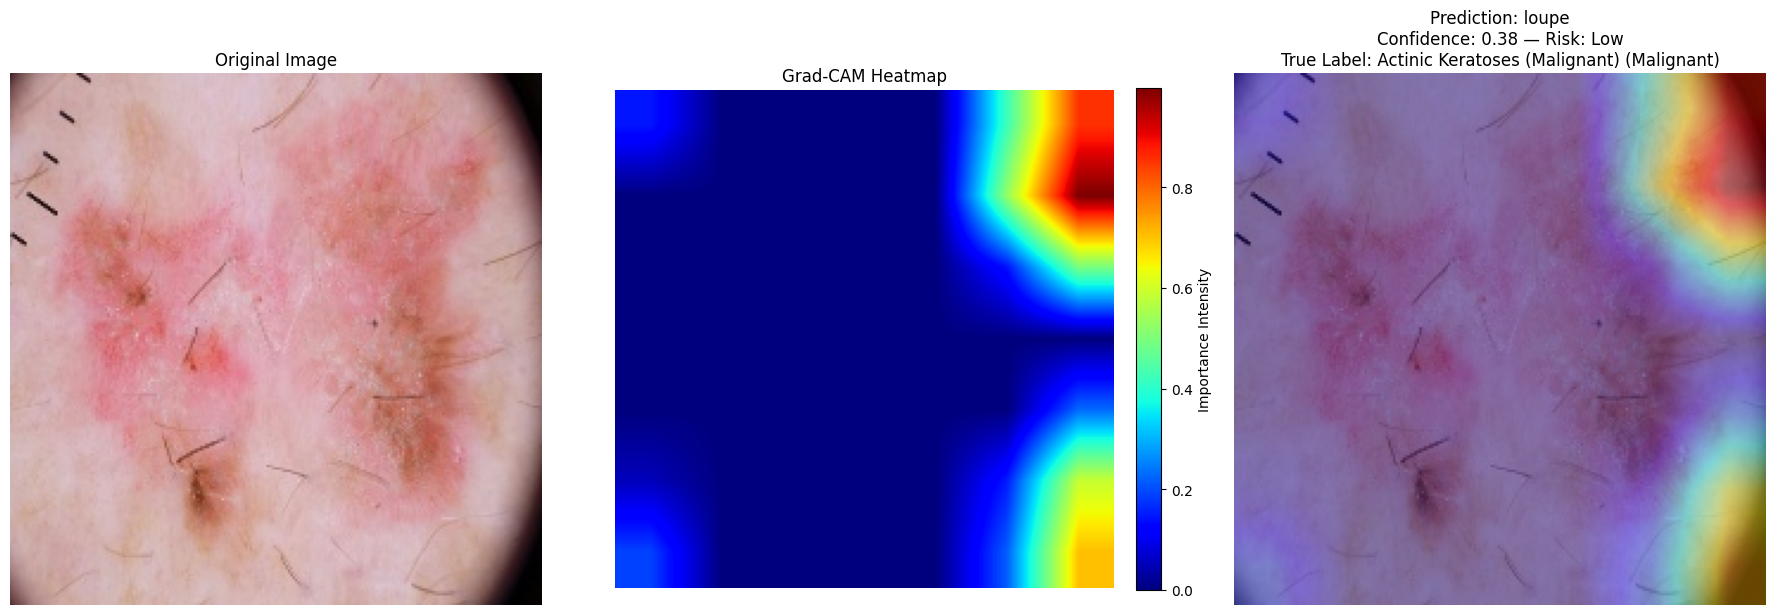

In [1]:
#resnet101

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# === Load model ===
model = ResNet101(weights='imagenet')

# === Image and metadata paths ===
img_path = os.path.join('HAM10000_split', 'test_224', 'akiec', 'ISIC_0024450.jpg')
metadata_path = 'HAM10000_metadata'

# === Load and preprocess image ===
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# === Predict ===
preds = model.predict(x)
decoded = decode_predictions(preds, top=3)[0]
pred_label = decoded[0][1]
pred_confidence = decoded[0][2]
pred_class = np.argmax(preds[0])

# === Risk interpretation ===
risk = "High" if pred_confidence >= 0.85 else "Moderate" if pred_confidence >= 0.60 else "Low"

# === Load metadata CSV ===
label_map = {
    'akiec': 'Actinic Keratoses (Malignant)', 'bcc': 'Basal Cell Carcinoma (Malignant)',
    'bkl': 'Benign Keratosis (Benign)', 'df': 'Dermatofibroma (Benign)',
    'mel': 'Melanoma (Malignant)', 'nv': 'Melanocytic Nevi (Benign)',
    'vasc': 'Vascular Lesion (Benign)'
}
malignant_labels = {'akiec', 'bcc', 'mel'}
metadata = pd.read_csv(metadata_path)
img_id = os.path.basename(img_path).split('.')[0]
dx_row = metadata[metadata['image_id'] == img_id]
if dx_row.empty:
    actual_dx, dx_type = 'Unknown', 'Unknown'
else:
    dx = dx_row.iloc[0]['dx']
    actual_dx = label_map.get(dx, dx)
    dx_type = 'Malignant' if dx in malignant_labels else 'Benign'

# === Grad-CAM ===
grad_model = Model(inputs=model.inputs,
                   outputs=[model.get_layer('conv5_block3_out').output, model.output])
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    loss = predictions[:, pred_class]
grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)
heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap_np = heatmap.numpy()

# === Display ===
img_cv = cv2.imread(img_path)
img_cv = cv2.resize(img_cv, (224, 224))
heatmap_resized = cv2.resize(heatmap_np, (224, 224))
heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap_color, 0.4, 0)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)); axs[0].set_title("Original Image"); axs[0].axis('off')
heatmap_plot = axs[1].imshow(heatmap_resized, cmap='jet'); axs[1].set_title("Grad-CAM Heatmap"); axs[1].axis('off')
cbar = plt.colorbar(heatmap_plot, ax=axs[1], fraction=0.046, pad=0.04); cbar.set_label('Importance Intensity')
axs[2].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
axs[2].set_title(f"Prediction: {pred_label}\nConfidence: {pred_confidence:.2f} — Risk: {risk}\nTrue Label: {actual_dx} ({dx_type})")
axs[2].axis('off')
plt.tight_layout()
plt.show()


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


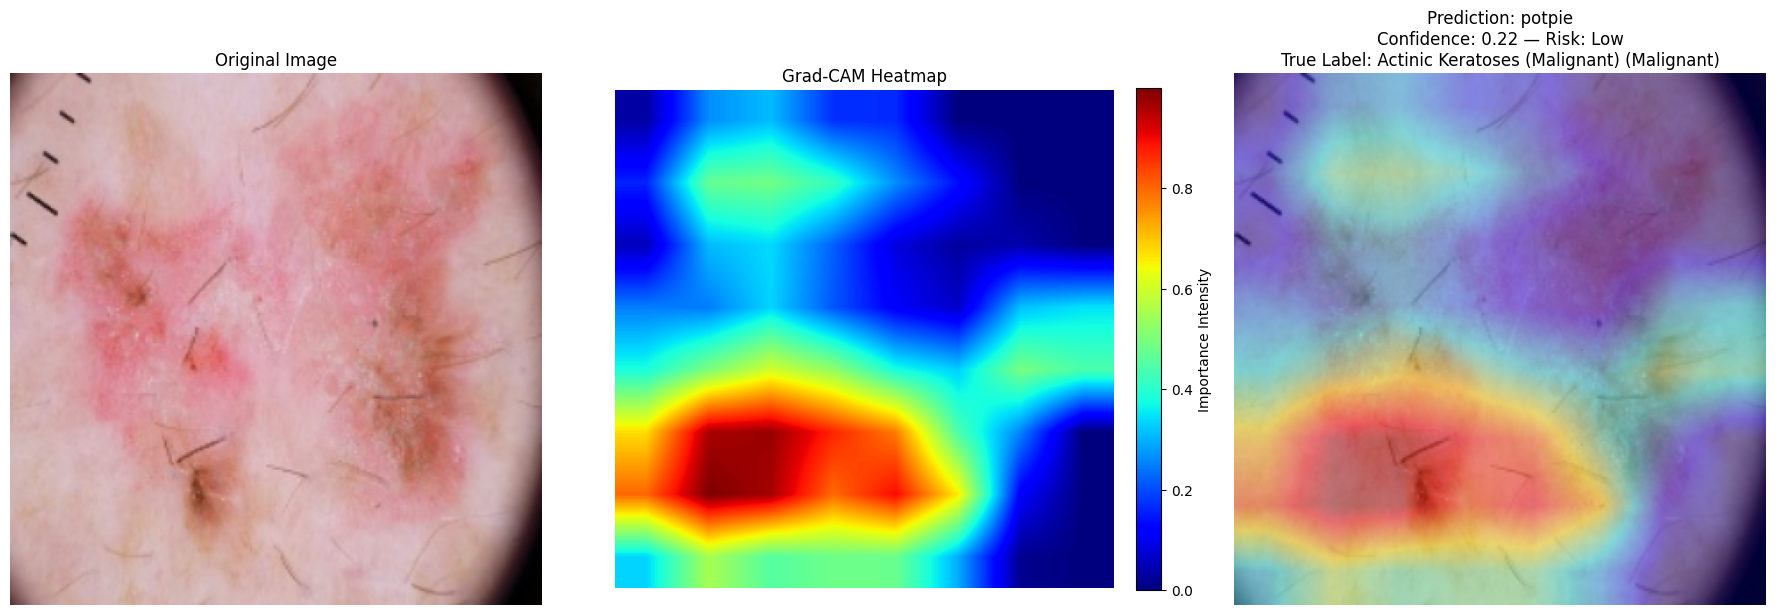

In [2]:
#inception code 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# === Load model ===
model = InceptionV3(weights='imagenet')

# === Image and metadata paths ===
img_path = os.path.join('HAM10000_split', 'test_224', 'akiec', 'ISIC_0024450.jpg')
metadata_path = 'HAM10000_metadata'

# === Load and preprocess image ===
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# === Predict ===
preds = model.predict(x)
decoded = decode_predictions(preds, top=3)[0]
pred_label = decoded[0][1]
pred_confidence = decoded[0][2]
pred_class = np.argmax(preds[0])

# === Risk interpretation ===
risk = "High" if pred_confidence >= 0.85 else "Moderate" if pred_confidence >= 0.60 else "Low"

# === Load metadata CSV ===
label_map = {
    'akiec': 'Actinic Keratoses (Malignant)', 'bcc': 'Basal Cell Carcinoma (Malignant)',
    'bkl': 'Benign Keratosis (Benign)', 'df': 'Dermatofibroma (Benign)',
    'mel': 'Melanoma (Malignant)', 'nv': 'Melanocytic Nevi (Benign)',
    'vasc': 'Vascular Lesion (Benign)'
}
malignant_labels = {'akiec', 'bcc', 'mel'}
metadata = pd.read_csv(metadata_path)
img_id = os.path.basename(img_path).split('.')[0]
dx_row = metadata[metadata['image_id'] == img_id]
if dx_row.empty:
    actual_dx, dx_type = 'Unknown', 'Unknown'
else:
    dx = dx_row.iloc[0]['dx']
    actual_dx = label_map.get(dx, dx)
    dx_type = 'Malignant' if dx in malignant_labels else 'Benign'

# === Grad-CAM ===
grad_model = Model(inputs=model.inputs,
                   outputs=[model.get_layer('mixed10').output, model.output])
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    loss = predictions[:, pred_class]
grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)
heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap_np = heatmap.numpy()

# === Display ===
img_cv = cv2.imread(img_path)
img_cv = cv2.resize(img_cv, (299, 299))
heatmap_resized = cv2.resize(heatmap_np, (299, 299))
heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap_color, 0.4, 0)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)); axs[0].set_title("Original Image"); axs[0].axis('off')
heatmap_plot = axs[1].imshow(heatmap_resized, cmap='jet'); axs[1].set_title("Grad-CAM Heatmap"); axs[1].axis('off')
cbar = plt.colorbar(heatmap_plot, ax=axs[1], fraction=0.046, pad=0.04); cbar.set_label('Importance Intensity')
axs[2].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
axs[2].set_title(f"Prediction: {pred_label}\nConfidence: {pred_confidence:.2f} — Risk: {risk}\nTrue Label: {actual_dx} ({dx_type})")
axs[2].axis('off')
plt.tight_layout()
plt.show()


91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


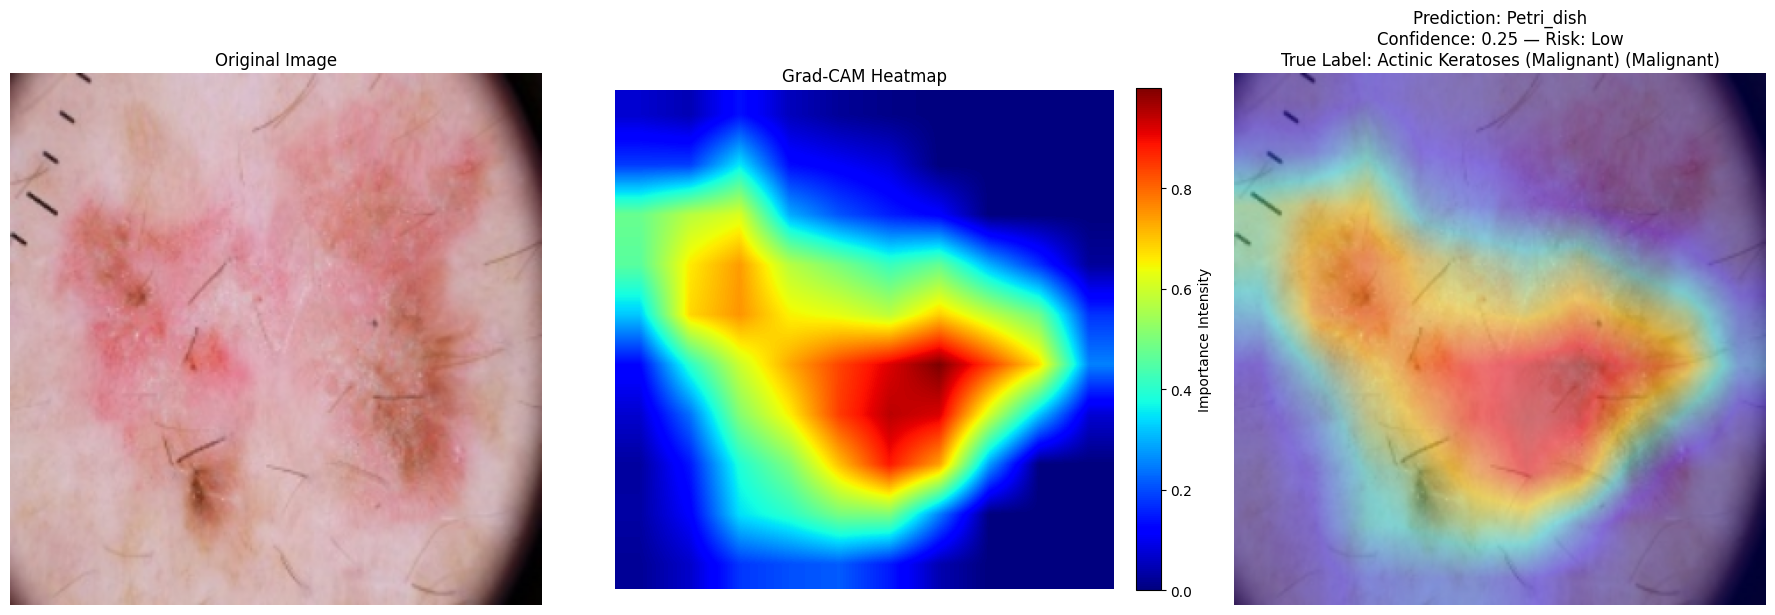

In [3]:
#xception
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# === Load model ===
model = Xception(weights='imagenet')

# === Image and metadata paths ===
img_path = os.path.join('HAM10000_split', 'test_224', 'akiec', 'ISIC_0024450.jpg')
metadata_path = 'HAM10000_metadata'

# === Load and preprocess image ===
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# === Predict ===
preds = model.predict(x)
decoded = decode_predictions(preds, top=3)[0]
pred_label = decoded[0][1]
pred_confidence = decoded[0][2]
pred_class = np.argmax(preds[0])

# === Risk interpretation ===
risk = "High" if pred_confidence >= 0.85 else "Moderate" if pred_confidence >= 0.60 else "Low"

# === Load metadata CSV ===
label_map = {
    'akiec': 'Actinic Keratoses (Malignant)', 'bcc': 'Basal Cell Carcinoma (Malignant)',
    'bkl': 'Benign Keratosis (Benign)', 'df': 'Dermatofibroma (Benign)',
    'mel': 'Melanoma (Malignant)', 'nv': 'Melanocytic Nevi (Benign)',
    'vasc': 'Vascular Lesion (Benign)'
}
malignant_labels = {'akiec', 'bcc', 'mel'}
metadata = pd.read_csv(metadata_path)
img_id = os.path.basename(img_path).split('.')[0]
dx_row = metadata[metadata['image_id'] == img_id]
if dx_row.empty:
    actual_dx, dx_type = 'Unknown', 'Unknown'
else:
    dx = dx_row.iloc[0]['dx']
    actual_dx = label_map.get(dx, dx)
    dx_type = 'Malignant' if dx in malignant_labels else 'Benign'

# === Grad-CAM ===
grad_model = Model(inputs=model.inputs,
                   outputs=[model.get_layer('block14_sepconv2_act').output, model.output])
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    loss = predictions[:, pred_class]
grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)
heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap_np = heatmap.numpy()

# === Display ===
img_cv = cv2.imread(img_path)
img_cv = cv2.resize(img_cv, (299, 299))
heatmap_resized = cv2.resize(heatmap_np, (299, 299))
heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap_color, 0.4, 0)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)); axs[0].set_title("Original Image"); axs[0].axis('off')
heatmap_plot = axs[1].imshow(heatmap_resized, cmap='jet'); axs[1].set_title("Grad-CAM Heatmap"); axs[1].axis('off')
cbar = plt.colorbar(heatmap_plot, ax=axs[1], fraction=0.046, pad=0.04); cbar.set_label('Importance Intensity')
axs[2].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
axs[2].set_title(f"Prediction: {pred_label}\nConfidence: {pred_confidence:.2f} — Risk: {risk}\nTrue Label: {actual_dx} ({dx_type})")
axs[2].axis('off')
plt.tight_layout()
plt.show()
